In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
df = pd.read_excel('/Users/rraj/Desktop/GlomData/GlomData_clean.xls', sheet_name='GIA0512')
df_stats = df.describe()
df_stats

,HXH,HXH.1,HXH.2,PTO,PTO.1,PTO.2,AA,AA.1,AA.2,PNE,...,IPBE.2,CNO,CNO.1,CNO.2,BTN,BTN.1,BTN.2,IMA,IMA.1,IMA.2
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.0,...,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.000123,0.010972,0.034009,0.000384,0.003456,0.014865,0.0,0.002500,0.013889,0.0,...,0.033971,0.000164,0.001754,0.013031,0.0,0.001294,0.011643,0.000563,0.012534,0.088809
std,0.001239,0.012543,0.025098,0.002776,0.009573,0.016028,0.0,0.006523,0.013267,0.0,...,0.025061,0.001660,0.004551,0.023071,0.0,0.007214,0.015400,0.003875,0.012821,0.034770
min,0.000000,0.000000,0.010646,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.022093
25%,0.000000,0.000000,0.017662,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.014291,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.068471
50%,0.000000,0.010856,0.024783,0.000000,0.000000,0.014939,0.0,0.000000,0.012550,0.0,...,0.027907,0.000000,0.000000,0.005127,0.0,0.000000,0.010290,0.000000,0.012386,0.085428
75%,0.000000,0.015549,0.040857,0.000000,0.000000,0.022933,0.0,0.000000,0.017588,0.0,...,0.047030,0.000000,0.000000,0.016776,0.0,0.000000,0.016868,0.000000,0.018138,0.106025
max,0.012509,0.063781,0.128328,0.023162,0.074673,0.069774,0.0,0.029513,0.077070,0.0,...,0.117362,0.016765,0.020428,0.124436,0.0,0.064051,0.067770,0.036457,0.062720,0.199837


In [3]:
from typing import List

def label_to_idx(labels: List[str]):
    prev_label = ' '
    prev_idx = -1
    idx = []
    for label in labels:
        if prev_label[:3] not in label:
            prev_label = label
            prev_idx += 1
        idx.append(prev_idx)
    return idx

idxs = label_to_idx(list(df.columns))
LABELS_TO_IDX_DICT = {label: idx for idx, label in zip(idxs, list(df.columns))}

In [4]:
df = df.T
df = df[df_stats.T['mean'] > 0.002]
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
print(f"train_size={train_df.size//102}, test_size={test_df.size//102}")

train_size=89, test_size=10


In [5]:
import torch
from torch.utils.data import Dataset
from typing import Dict


class OlfactoryData(Dataset):
    def __init__(self, data: pd.DataFrame, labels_to_idx_dict: Dict):
        self.data = data.values
        self.labels = [labels_to_idx_dict[label] for label in list(data.index)]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sample = torch.tensor(self.data[index,:]).float()
        return sample, self.labels[index] 


train_data = OlfactoryData(train_df, LABELS_TO_IDX_DICT)
test_data = OlfactoryData(test_df, LABELS_TO_IDX_DICT)

In [6]:
import transformations
from transformations import Scale, ToVector
from layers import DiscriminationModule, AdaptationModule
from initialization import RandomInitializer, IdentityInitializer
from loading import TripletLoader
from plotting import LossPlotter

transforms = transformations.Compose([Scale(), ToVector()])
train_loader = TripletLoader(train_data, transforms=transforms)

out_dim = 100

layer1 = DiscriminationModule(out_dim, RandomInitializer(102))
layer2 = AdaptationModule(out_dim, IdentityInitializer(), lr=0.01)
layer3 = AdaptationModule(out_dim, IdentityInitializer(), lr=0.01)

plotter = LossPlotter()

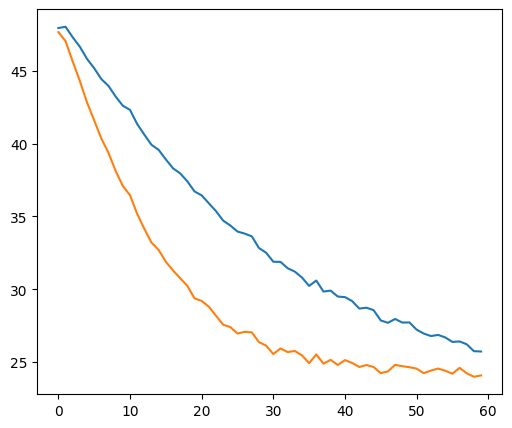

In [7]:
from tqdm import tqdm

nepochs = 60
nbatches = 50
batch_size = 55
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0.0, 0.0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in train_loader(batch_size):
            x = layer1(x)
            x = layer2(x)
            x = layer3(x)
            
        batch_loss1 += layer2.loss/batch_size
        batch_loss2 += layer3.loss/batch_size
        
        layer1.organize()
        layer2.organize()
        layer3.organize()
        
    plotter([batch_loss1, batch_loss2])

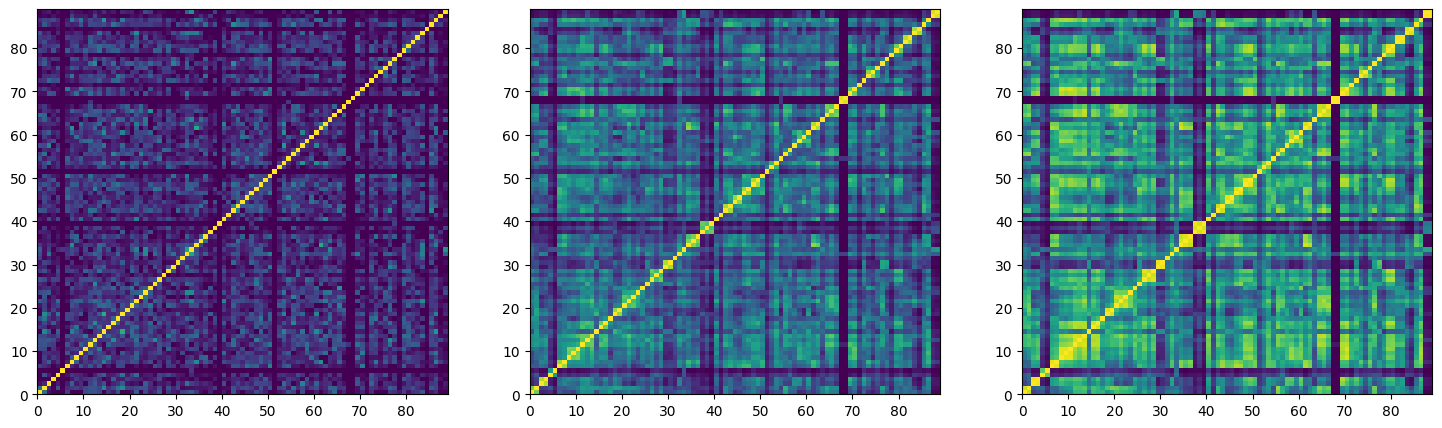

In [16]:
from testing import TestModule
from plotting import SimilarityPlotter

test_module = TestModule()
test_outputs, targets = test_module([layer1, layer2, layer3], test_dataset=train_data, input_transforms=transforms)
target_indexes = torch.argsort(torch.tensor(targets))
test_outputs = {key: value[target_indexes,:] for key, value in test_outputs.items()}
test_plotter = SimilarityPlotter(3)
test_plotter(test_outputs)

In [17]:
print(torch.tensor(targets)[target_indexes])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  7,  7,  8,
         9,  9, 10, 10, 10, 14, 15, 16, 18, 18, 18, 19, 19, 20, 21, 22, 24, 24,
        24, 25, 25, 25, 26, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 33, 33, 33,
        34, 35, 36, 39, 43, 43, 43, 44, 44, 45, 46, 46, 46, 47, 47, 48, 48, 48,
        49, 50, 50, 53, 54, 55, 56, 56, 56, 57, 57, 59, 59, 60, 61, 62, 62])


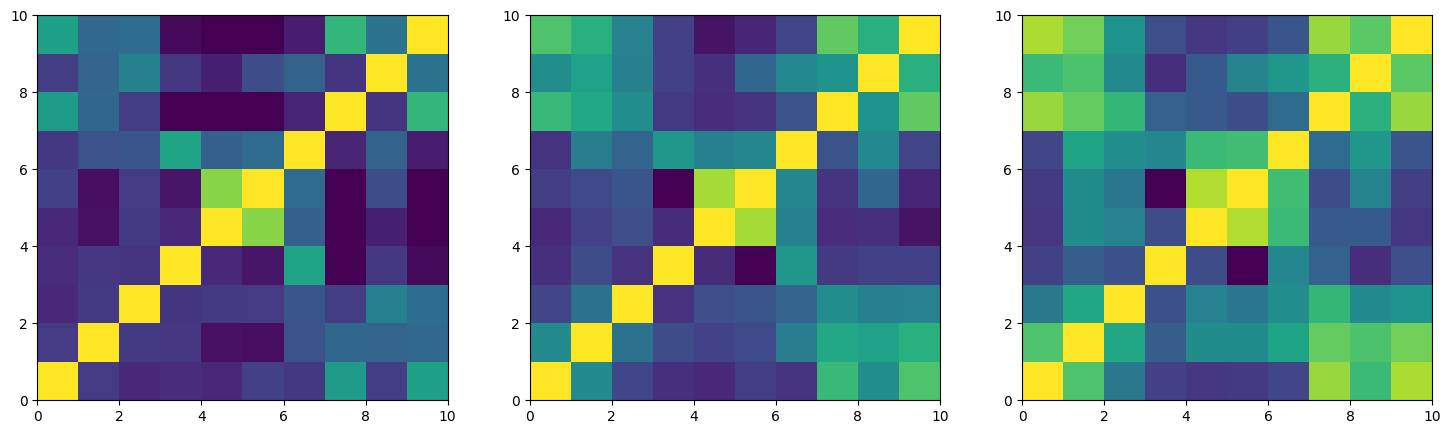

In [13]:
test_outputs, targets = test_module([layer1, layer2, layer3], test_dataset=test_data, input_transforms=transforms)
target_indexes = torch.argsort(torch.tensor(targets))
test_outputs = {key: value[target_indexes,:] for key, value in test_outputs.items()}
test_plotter(test_outputs)

In [15]:
print(torch.tensor(targets)[target_indexes])

tensor([ 7, 20, 21, 52, 54, 54, 55, 57, 58, 58])


Text(0.5, 1.0, 'Adaptation2')

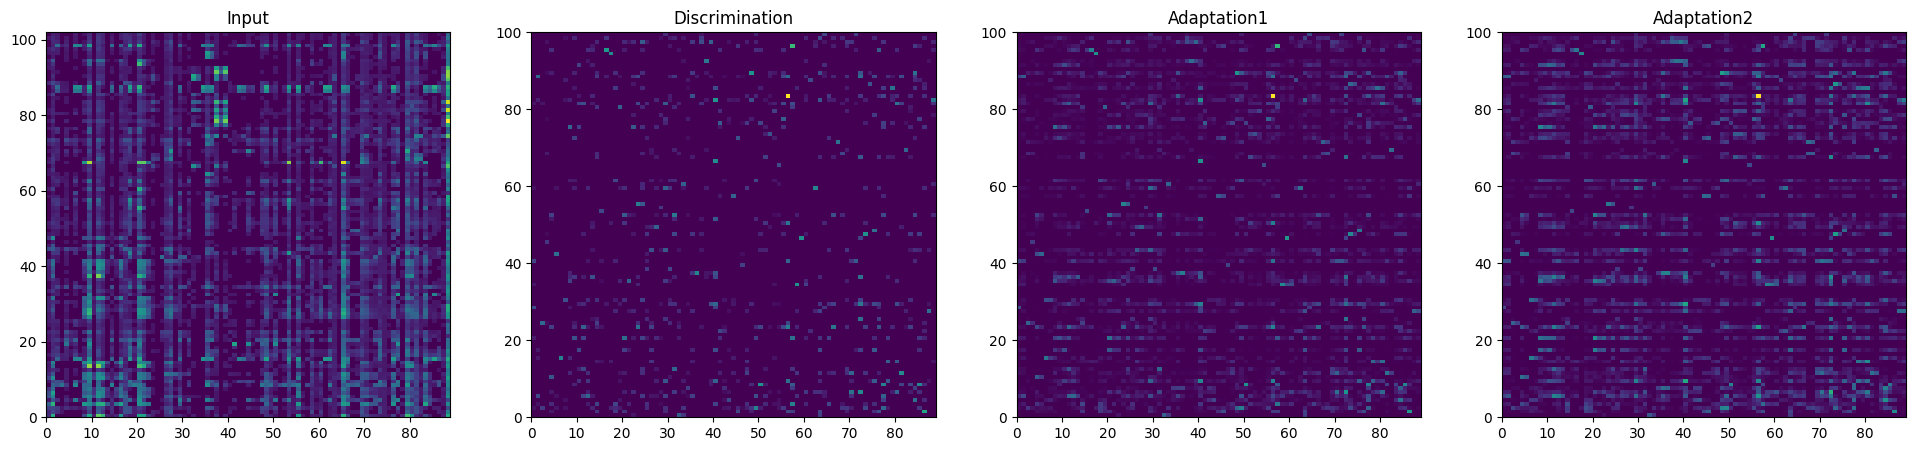

In [29]:
inputs = torch.tensor(train_df.values)
target_indexes = torch.argsort(targets)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].pcolormesh(inputs[target_indexes,:].T); ax[0].set_title('Input')
ax[1].pcolormesh(test_outputs[0][target_indexes,:].T); ax[1].set_title('Discrimination')
ax[2].pcolormesh(test_outputs[1][target_indexes,:].T); ax[2].set_title('Adaptation1')
ax[3].pcolormesh(test_outputs[2][target_indexes,:].T); ax[3].set_title('Adaptation2')

In [33]:
from transformations import Transform
from torch.utils.data import DataLoader

def test_corruption(data: Dataset, transform: Transform):
    transform1 = transformations.Compose([Scale(), ToVector()])
    transform2 = transformations.Compose([Scale(), transform, ToVector()])
    
    loader = DataLoader(data)
    
    out_clean = torch.empty(0)
    out_corrupted = torch.empty(0)
    
    for x, _ in loader:
        x_clean = transform1(x)
        out_clean = torch.cat((out_clean, layer1(x_clean, train=False)), dim=0) 
        
        x_corrupted = transform2(x)
        out_corrupted  = torch.cat((out_corrupted , layer1(x_corrupted, train=False)), dim=0)
    return out_clean, out_corrupted

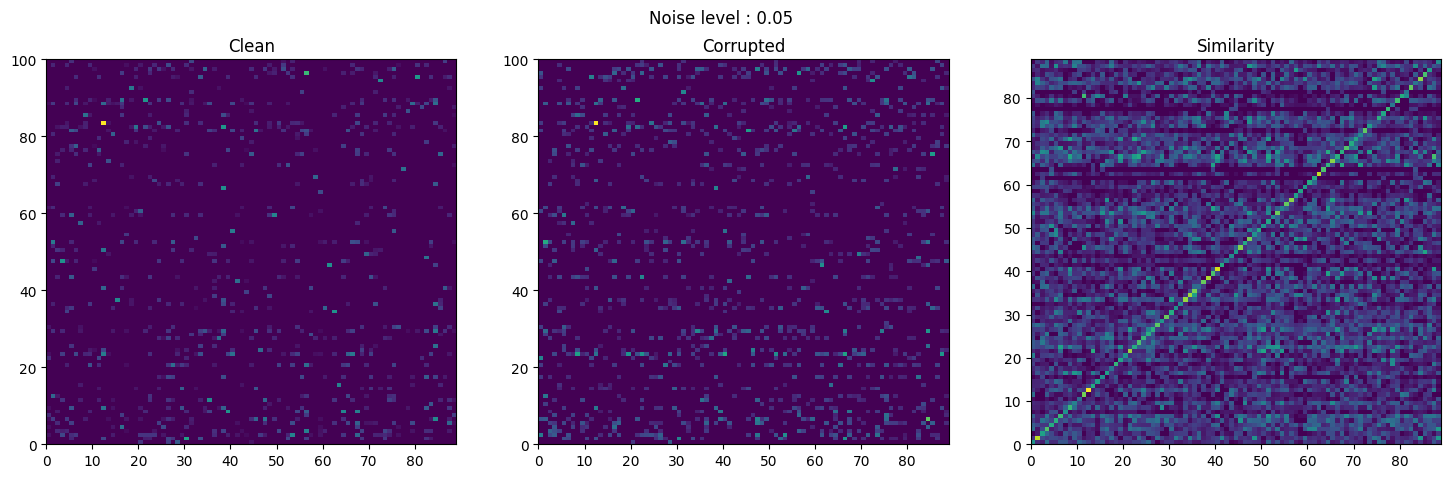

In [46]:
from transformations import AddNoise

noise_level = 0.05
out_clean, out_corrupted = test_corruption(train_data, AddNoise(noise_level))
out_clean_norm = normalize(out_clean.T, p=2, dim=0)
out_corrupted_norm = normalize(out_corrupted.T, p=2, dim=0)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].pcolormesh(out_clean.T); ax[0].set_title('Clean')
ax[1].pcolormesh(out_corrupted.T); ax[1].set_title('Corrupted')
ax[2].pcolormesh(torch.mm(out_clean_norm.T, out_corrupted_norm)); ax[2].set_title('Similarity')
fig.suptitle(f"Noise level : {noise_level}")
plt.savefig(f"NoiseCorruption{100*noise_level:0.0f}")

In [ ]:
from transformations import Mask

noise_level = 0.05
out_clean, out_corrupted = test_corruption(train_data, AddNoise(noise_level))
out_clean_norm = normalize(out_clean.T, p=2, dim=0)
out_corrupted_norm = normalize(out_corrupted.T, p=2, dim=0)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].pcolormesh(out_clean.T); ax[0].set_title('Clean')
ax[1].pcolormesh(out_corrupted.T); ax[1].set_title('Corrupted')
ax[2].pcolormesh(torch.mm(out_clean_norm.T, out_corrupted_norm)); ax[2].set_title('Similarity')
fig.suptitle(f"Noise level : {noise_level}")
plt.savefig(f"NoiseCorruption{100*noise_level:0.0f}")